# Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

## Инструкция по выполнению проекта

1. Загрузите и подготовьте данные.
2. Обучите разные модели с различными гиперпараметрами.
3. Проанализируйте скорость работы и качество моделей.

Примечания:
- Для оценки качества моделей применяйте метрику RMSE.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.

## Описание данных

Данные находятся в файле `/datasets/autos.csv`

### Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

### Целевой признак
- Price — цена (евро)

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor, Pool

from lightgbm import LGBMRegressor

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
data = pd.read_csv('/datasets/autos.csv')

## Изучение данных

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [5]:
data.sample(20)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
81525,2016-03-14 18:51:18,5750,suv,2005,manual,126,rav,150000,12,petrol,toyota,no,2016-03-14 00:00:00,0,30890,2016-03-14 18:51:18
258864,2016-03-17 10:36:18,950,sedan,1998,manual,65,astra,150000,11,petrol,opel,no,2016-03-17 00:00:00,0,13403,2016-03-17 10:36:18
209259,2016-03-24 09:54:10,1600,wagon,2000,manual,114,almera,80000,10,petrol,nissan,no,2016-03-24 00:00:00,0,82418,2016-03-25 18:48:05
229910,2016-03-23 19:55:57,999,small,1996,auto,60,fiesta,125000,12,petrol,ford,no,2016-03-23 00:00:00,0,49090,2016-03-23 19:55:57
238577,2016-03-30 22:54:18,4999,bus,2009,manual,125,altea,150000,8,petrol,seat,no,2016-03-30 00:00:00,0,57250,2016-04-01 21:18:56
293590,2016-04-04 00:50:46,17900,convertible,1989,manual,0,other,30000,7,petrol,mini,no,2016-04-03 00:00:00,0,46446,2016-04-06 08:16:19
334020,2016-03-07 22:37:19,5400,bus,2005,manual,150,touran,150000,6,petrol,volkswagen,no,2016-03-07 00:00:00,0,72649,2016-03-22 05:47:40
285326,2016-03-24 14:51:31,399,sedan,1997,manual,44,golf,150000,9,petrol,volkswagen,no,2016-03-24 00:00:00,0,4288,2016-03-30 16:45:50
218362,2016-03-26 22:48:36,1500,NaN,2017,manual,128,other,150000,12,NaN,citroen,NaN,2016-03-26 00:00:00,0,33790,2016-03-27 00:43:28
53328,2016-04-02 22:57:31,9999,small,2009,manual,174,cooper,125000,1,petrol,mini,no,2016-04-02 00:00:00,0,63303,2016-04-06 14:44:56


На первый взгляд мы можем увидеть что у нас 354369 записи, с пропусками в некоторых столбцах, а так же 0 в столбцах Price, Power, RegistrationMonth и RegistrationYear со значением 1000.

## Обработка данных

Проверим данные на полные дубликаты.

In [6]:
data.duplicated().sum()

4

У нас в данных обнаружилось 4 полных дубликата - удалим их.

In [7]:
data.drop_duplicates(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        316875 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            334532 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  NotRepaired        283211 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), object(

Сразу очистим данные от не нужных нам признаков, таких как DateCrawled, DateCreated, PostalCode, LastSeen и NumberOfPictures, так как в нём везде 0 - они не несут полезности для обучения модели и никак не влияют на расчёт стоимости автомобиля.

In [8]:
data = data.drop(['DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen', 'NumberOfPictures'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354365 non-null  int64 
 1   VehicleType        316875 non-null  object
 2   RegistrationYear   354365 non-null  int64 
 3   Gearbox            334532 non-null  object
 4   Power              354365 non-null  int64 
 5   Model              334660 non-null  object
 6   Kilometer          354365 non-null  int64 
 7   RegistrationMonth  354365 non-null  int64 
 8   FuelType           321470 non-null  object
 9   Brand              354365 non-null  object
 10  NotRepaired        283211 non-null  object
dtypes: int64(5), object(6)
memory usage: 32.4+ MB


#### Заполняем пропуски в данных.

Для заполнения Model, VehicleType, FuelType и Gearbox сделаем функцию, которая на вход будет принимать набор параметров для группировки и целевой параметр для заполнения. В случае отсутсвия подходящего значения будем ставить категорию UNK(unknown). Ведь за один год компании выпускают определенный модельный ряд, который изменяется раз в несколько лет. А узнав модель и год выпуска, мы можем подставить отсальные параметры.

In [9]:
def filler(row, features, target_feature, mapper):
    if (type(row[target_feature])) != str:
        return mapper.get(tuple(row[features]), "UNK")
    return row[target_feature]

def fill_na_by_params_group(dataset, features, target_feature):
    mapper = dataset.groupby(by=features)[target_feature].apply(lambda x: x.mode()).to_dict()
    mapper = {(key[:-1]): value for key, value in mapper.items()}
    
    dataset[target_feature] = dataset.apply(lambda row: filler(row, features, target_feature, mapper), axis=1)
    return dataset


In [10]:
data = fill_na_by_params_group(data, ['Brand', 'RegistrationYear', 'RegistrationMonth'], 'Model')
data[data['VehicleType'] == 'UNK'].shape

(0, 11)

In [11]:
data = fill_na_by_params_group(data, ['Brand', 'Model', 'RegistrationYear', 'RegistrationMonth'], 'VehicleType')
data[data['VehicleType'] == 'UNK'].shape

(22927, 11)

In [12]:
data = fill_na_by_params_group(data, ['Brand', 'Model', 'RegistrationYear', 'RegistrationMonth', 'VehicleType'], 'FuelType')
data[data['FuelType'] == 'UNK'].shape

(4122, 11)

In [13]:
data = fill_na_by_params_group(data, ['Brand', 'Model', 'RegistrationYear', 'RegistrationMonth', 'VehicleType', 'FuelType'], 'Gearbox')
data[data['Gearbox'] == 'UNK'].shape

(3093, 11)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354365 non-null  int64 
 1   VehicleType        354365 non-null  object
 2   RegistrationYear   354365 non-null  int64 
 3   Gearbox            354365 non-null  object
 4   Power              354365 non-null  int64 
 5   Model              354365 non-null  object
 6   Kilometer          354365 non-null  int64 
 7   RegistrationMonth  354365 non-null  int64 
 8   FuelType           354365 non-null  object
 9   Brand              354365 non-null  object
 10  NotRepaired        283211 non-null  object
dtypes: int64(5), object(6)
memory usage: 32.4+ MB


С помощью функции заполнения нам удолось избавиться от пропусков, полностью заполнив столбец Model, а в остальных мы смогли заполнить 80% пропусков данными, за исключением VehicleType.

Поле NotRepaired мы не можем заполнить по принципу ранее, ведь всё зависит от случая, бывает что новая машина ездит на ремонт каждый месяц, а может ездить несколько лет, меняя расходники, поэтому пропуски в этом поле мы заполним значением "UNK"

In [15]:
data['NotRepaired'].fillna('UNK', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354365 non-null  int64 
 1   VehicleType        354365 non-null  object
 2   RegistrationYear   354365 non-null  int64 
 3   Gearbox            354365 non-null  object
 4   Power              354365 non-null  int64 
 5   Model              354365 non-null  object
 6   Kilometer          354365 non-null  int64 
 7   RegistrationMonth  354365 non-null  int64 
 8   FuelType           354365 non-null  object
 9   Brand              354365 non-null  object
 10  NotRepaired        354365 non-null  object
dtypes: int64(5), object(6)
memory usage: 32.4+ MB


## Анализ данных

Постороим pairplot, чтобы посмотреть нет ли у нас корреляции между данными и заодно посмотрим на все распределения.

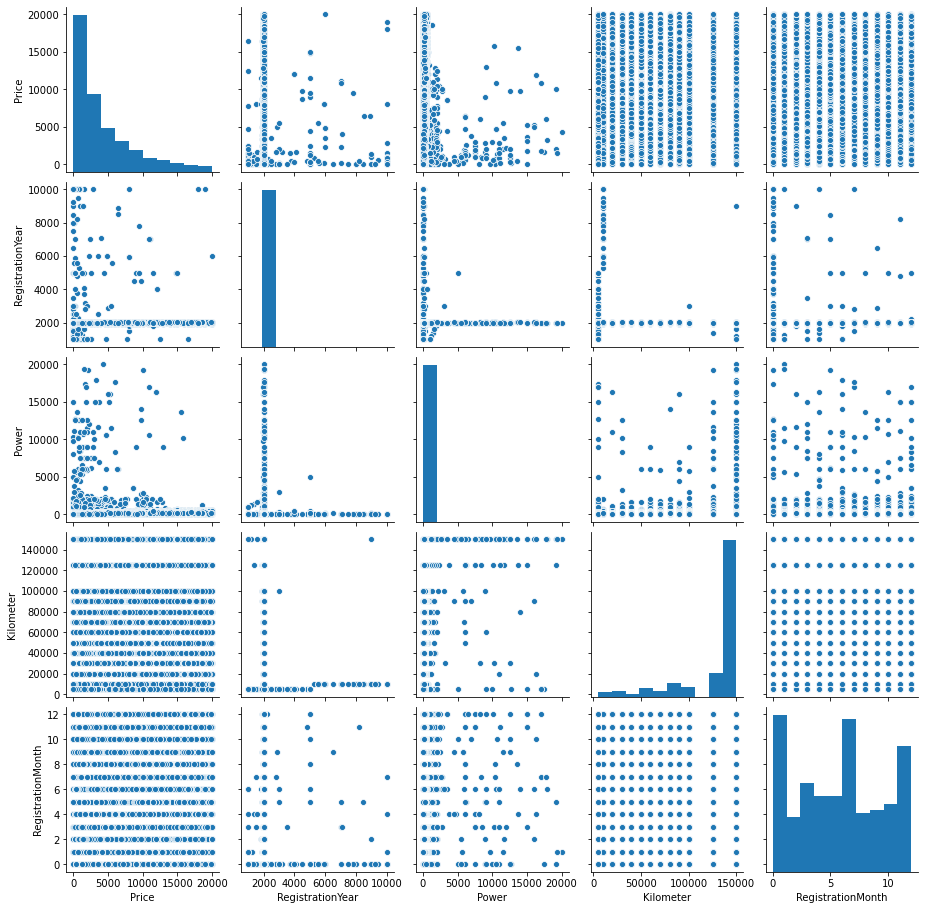

In [16]:
sns.pairplot(data);

pairplot показал нам, что в датасете между данными нет мультиколлинеарности, а так же дал понять, что нам стоит поближе посмотреть на распределения.

Посмотрим на распределение цены автомобилей.

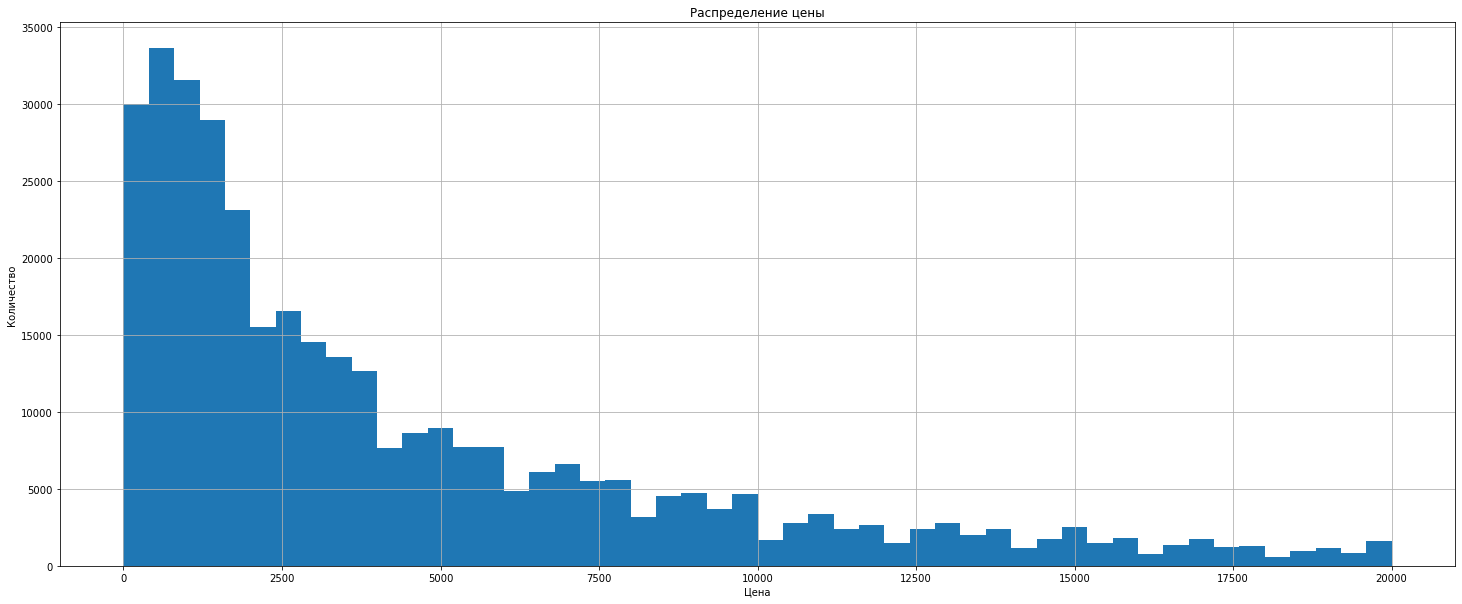

In [17]:
plt.figure(figsize=(25,10))
ax = data['Price'].hist(bins=50)
ax.set_title('Распределение цены')
ax.set_xlabel('Цена')
ax.set_ylabel('Количество')
plt.show()

На гистограмме мы можем увидеть большую концетрацию значений возле 0, посмотрим сколько их и что это за автомобили.

In [18]:
data_zero_price = data[data['Price'] == 0]
display(data_zero_price.sample(10))
print(data_zero_price.shape[0])

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
83390,0,sedan,1995,manual,0,3er,5000,0,petrol,bmw,UNK
108535,0,UNK,2016,manual,0,golf,150000,7,gasoline,volkswagen,no
96976,0,sedan,2003,manual,125,vectra,150000,11,gasoline,opel,UNK
173232,0,wagon,2011,manual,140,golf,150000,4,gasoline,volkswagen,no
197253,0,UNK,2016,manual,0,golf,150000,7,petrol,volkswagen,UNK
207952,0,small,1999,manual,82,a_klasse,150000,8,petrol,mercedes_benz,no
184287,0,small,2000,manual,0,golf,150000,0,petrol,volkswagen,UNK
67007,0,sedan,2000,auto,193,5er,150000,5,petrol,bmw,UNK
307654,0,wagon,1997,manual,0,other,150000,0,UNK,volvo,UNK
349129,0,UNK,2014,auto,0,1er,50000,1,UNK,bmw,UNK


10772


Так как это целевой признак и таких данных около 3% от общего датасета - подходящим решением будет удалить эти данные, ведь мы не знаем причину нулевой цены, это может быть как ошибка выгрузки, а так же кто-то мог отдать машину за бесплатно.

In [19]:
data = data[data['Price'] > 0]
data.shape[0]

343593

Рассмотрим распределение по мощности автомобилей.

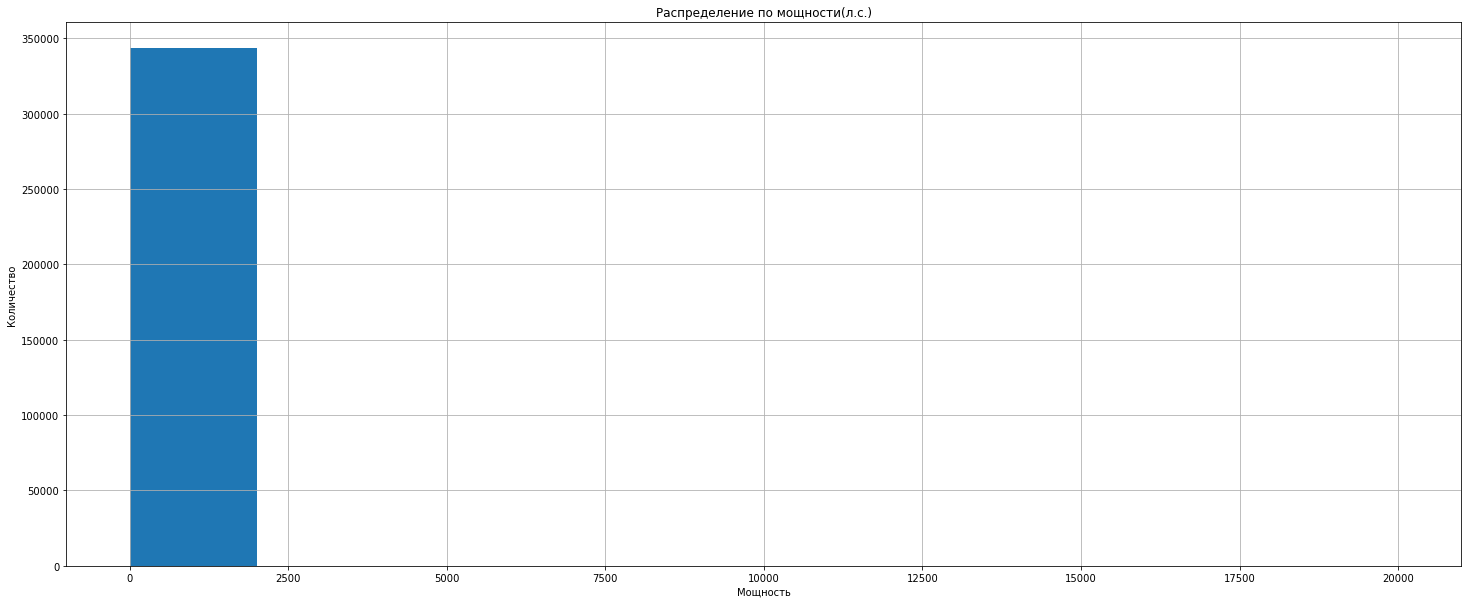

In [20]:
plt.figure(figsize=(25,10))
ax = data['Power'].hist(bins=10)
ax.set_title('Распределение по мощности(л.с.)')
ax.set_xlabel('Мощность')
ax.set_ylabel('Количество')
plt.show()

Тут у нас явно есть выбросы, построим boxplot, что бы по подробнее посмотреть на выбросы.

<AxesSubplot:xlabel='Power'>

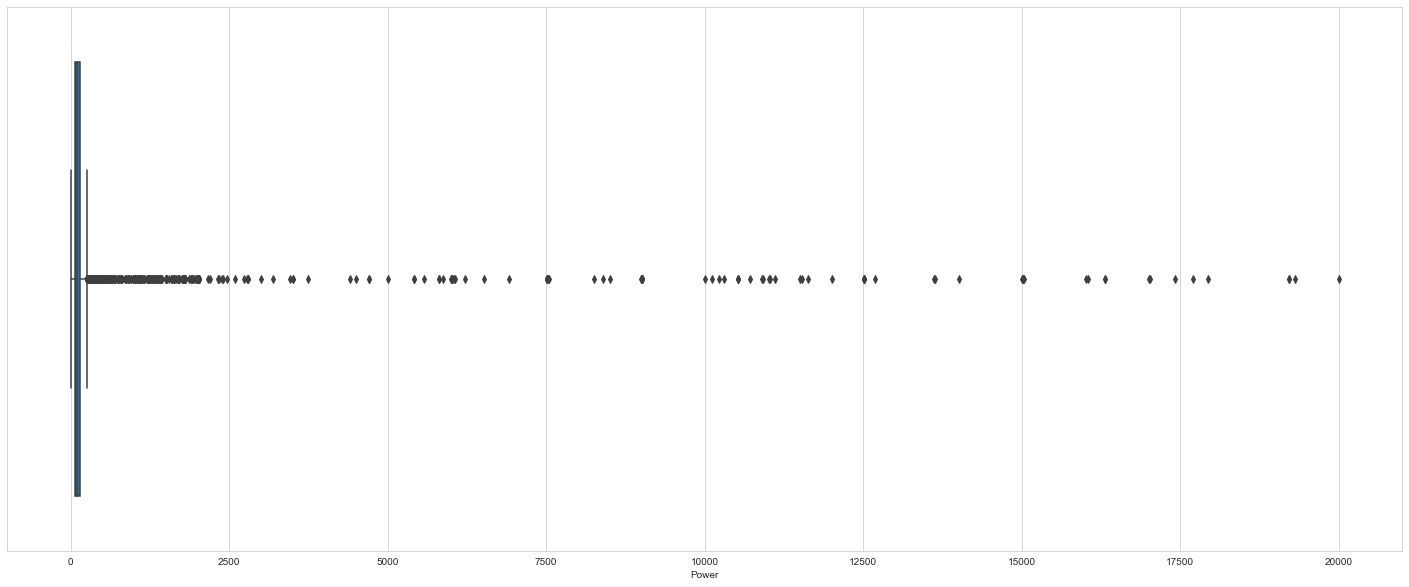

In [21]:
sns.set_style('whitegrid') 
plt.figure(figsize=(25,10))
sns.boxplot(x = 'Power', data = data) 

Мы видим что у нас есть автомобили с какой-то невероятной мощностью в 20000 лс, даже у одного из самых быстрых автомобилей Bugatti Chiron всего лишь 1500 л.с., так что будем реалистами и ораничимся в 400 л.с. Возможно ошибка была при выгрузке данных и где-то промахнулись с запятой.

In [22]:
data = data[data['Power'] < 400]
data.shape[0]

342842

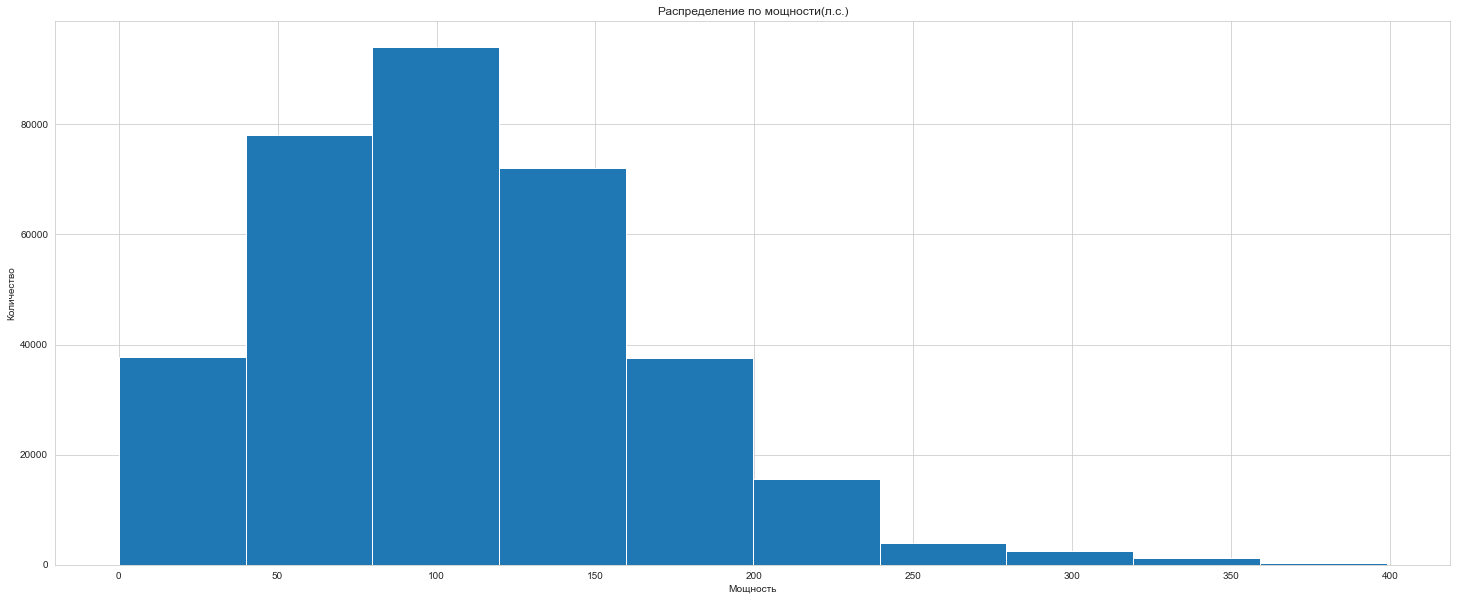

In [23]:
plt.figure(figsize=(25,10))
ax = data['Power'].hist(bins=10)
ax.set_title('Распределение по мощности(л.с.)')
ax.set_xlabel('Мощность')
ax.set_ylabel('Количество')
plt.show()

Так же на pairplot необычно выглядит распределение года регистрации, посмотрим на него поближе.

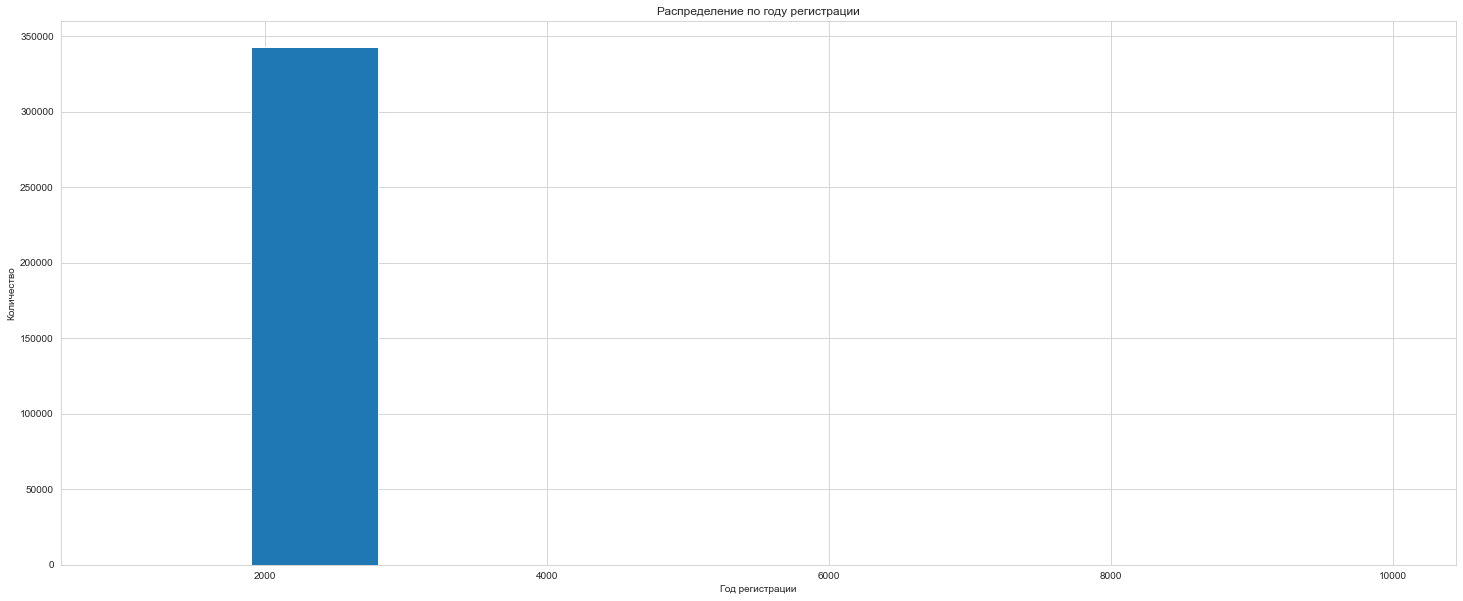

In [24]:
plt.figure(figsize=(25,10))
ax = data['RegistrationYear'].hist(bins=10)
ax.set_title('Распределение по году регистрации')
ax.set_xlabel('Год регистрации')
ax.set_ylabel('Количество')
plt.show()

Тут у нас тоже явно есть выбросы, построим boxplot, что бы по подробнее посмотреть на выбросы.

<AxesSubplot:xlabel='RegistrationYear'>

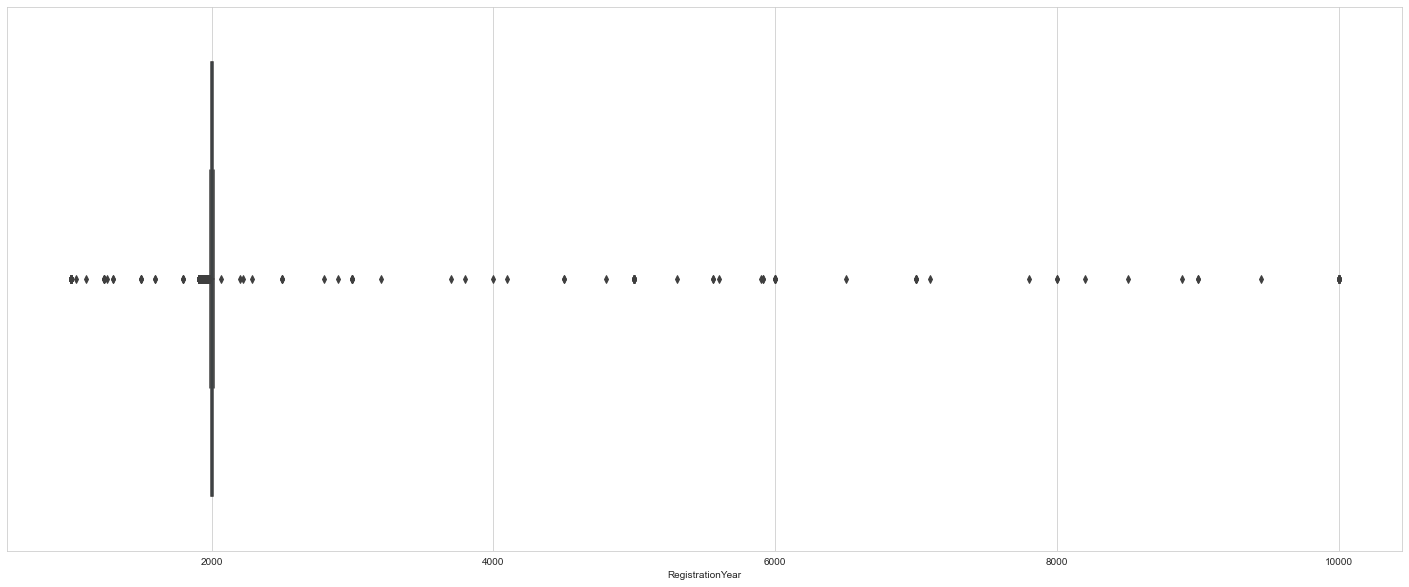

In [25]:
sns.set_style('whitegrid') 
plt.figure(figsize=(25,10))
sns.boxplot(x = 'RegistrationYear', data = data) 

Здесь мы можем увидеть как машины из далёкого прошлого, так и машины из далёкого будущего. С верху ограничимся 2020 годом, а снизу 1965, если машины из будущего нам продать не могут, то раритет из недалёкого прошлого более чем.

In [26]:
data = data[(data['RegistrationYear'] >= 1965) & (data['RegistrationYear'] <= 2020)]

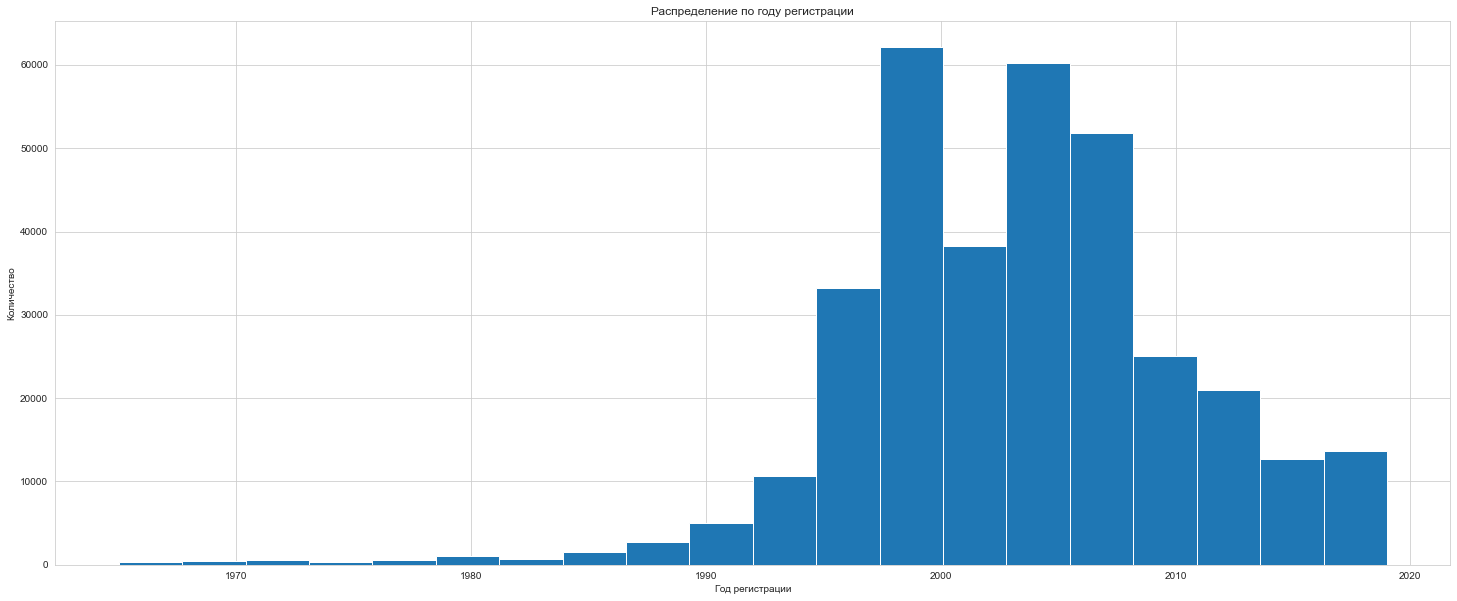

In [27]:
plt.figure(figsize=(25,10))
ax = data['RegistrationYear'].hist(bins=20)
ax.set_title('Распределение по году регистрации')
ax.set_xlabel('Год регистрации')
ax.set_ylabel('Количество')
plt.show()

Посмотрим на распеределение машин по пробегу.

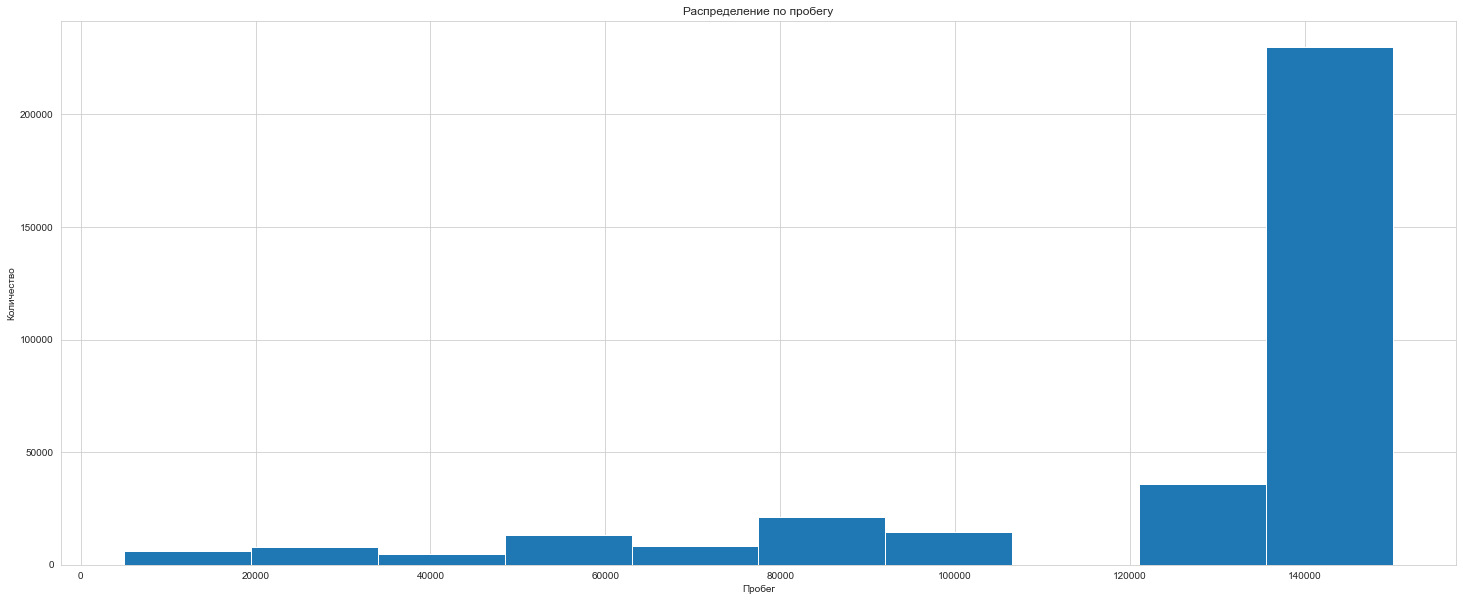

In [28]:
plt.figure(figsize=(25,10))
ax = data['Kilometer'].hist(bins=10)
ax.set_title('Распределение по пробегу')
ax.set_xlabel('Пробег')
ax.set_ylabel('Количество')
plt.show()

Мы видим большую концетрацию значений возле 150000, это могло быть максимальное доступное значение для установки текущего пробега, а так же это может быть некий психологический порог, после которого люди решают продать машину. Оставим всё как есть.

## Обучение моделей

Подготовим наши данные для обучения, разделим данные на обучающую и валидационную выборки.

In [29]:
y = data.Price
X = data.drop('Price', axis=1)

Построим три разных модели: LinearRegression, CatBoostRegressor и 

Для линейной регрессии сделаем стандартизацию данных воспользовавшись StandardScaler и преобразование категориальных данных с помощью техники One-hot-encoding.

In [30]:
scaler = StandardScaler()
X_transformed = X.copy()
X_transformed[['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']] = scaler.fit_transform(X_transformed[['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']])
X.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,small,1993,manual,0,golf,150000,0,petrol,volkswagen,UNK
1,coupe,2011,manual,190,a3,125000,5,gasoline,audi,yes
2,suv,2004,auto,163,grand,125000,8,gasoline,jeep,UNK
3,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


In [31]:
X_transformed = pd.get_dummies(X, columns=['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'])

In [32]:
X_transformed

,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_UNK,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,...,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_UNK,NotRepaired_no,NotRepaired_yes
0,1993,0,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,2011,190,125000,5,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2004,163,125000,8,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2001,75,150000,6,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,2008,69,90000,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354363,2000,0,150000,3,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
354365,2005,0,20000,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
354366,2000,101,125000,3,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
354367,1996,102,150000,3,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(X_transformed, y, test_size=.2, random_state=111)

In [34]:
linear_param_grid = {'normalize': [True, False], 'fit_intercept': [True, False]}

linear_grid = GridSearchCV(LinearRegression(), param_grid=linear_param_grid,
                   cv=5, n_jobs = -2)

In [35]:
%%time

linear_grid.fit(X_train, y_train)

CPU times: user 20.7 s, sys: 1.43 s, total: 22.2 s
Wall time: 55.1 s


GridSearchCV(cv=5, estimator=LinearRegression(), n_jobs=-2,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]})

In [36]:
linear_grid.best_params_

{'fit_intercept': True, 'normalize': False}

In [37]:
%%time
linear_predictions = linear_grid.predict(X_valid)

CPU times: user 990 ms, sys: 147 ms, total: 1.14 s
Wall time: 302 ms


In [38]:
print('LinearRegression RMSE: {}'.format(mean_squared_error(y_valid, linear_predictions) ** .5))

LinearRegression RMSE: 2666.7953026126715


In [39]:
lgb_parameters = {
    'max_depth': [6,8,10],
    'num_leaves':range(20,60,10),
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [30, 50, 100]
}

lgb_model = LGBMRegressor()
lgb_grid = GridSearchCV(estimator=lgb_model, param_grid = lgb_parameters, cv = 5, n_jobs=-2)

In [40]:
%%time
lgb_grid.fit(X_train, y_train)

/usr/local/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


CPU times: user 38.3 s, sys: 5.3 s, total: 43.6 s
Wall time: 8min 16s


GridSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=-2,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [6, 8, 10], 'n_estimators': [30, 50, 100],
                         'num_leaves': range(20, 60, 10)})

In [41]:
lgb_grid.best_estimator_.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 50,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [42]:
%%time
lgb_predictions = lgb_grid.predict(X_valid)

CPU times: user 4.51 s, sys: 473 ms, total: 4.98 s
Wall time: 690 ms


In [43]:
print('LGBMRegressor RMSE: {}'.format(mean_squared_error(y_valid, lgb_predictions) ** .5))

LGBMRegressor RMSE: 1733.1411438970463


In [44]:
X_boosting_train, X_boosting_valid, y_boosting_train, y_boosting_valid = train_test_split(X, y, test_size=.2, random_state=111)

In [45]:
cat_features = [0,2,4,6,7,8,9]

In [46]:
catboost_parameters = {
    'depth': [6,8,10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [30, 50, 100]
}

catboost_model = CatBoostRegressor(cat_features=cat_features)
catboost_grid = GridSearchCV(estimator=catboost_model, param_grid = catboost_parameters, cv = 5, n_jobs=-2)

In [47]:
%%time
catboost_grid.fit(X_boosting_train, y_boosting_train)

0:	learn: 4183.9215026	total: 167ms	remaining: 16.5s
1:	learn: 3907.8320138	total: 263ms	remaining: 12.9s
2:	learn: 3666.2190366	total: 364ms	remaining: 11.8s
3:	learn: 3454.4351545	total: 475ms	remaining: 11.4s
4:	learn: 3267.3156002	total: 572ms	remaining: 10.9s
5:	learn: 3102.8683987	total: 657ms	remaining: 10.3s
6:	learn: 2963.2952609	total: 742ms	remaining: 9.86s
7:	learn: 2831.2663166	total: 838ms	remaining: 9.64s
8:	learn: 2717.9875862	total: 934ms	remaining: 9.44s
9:	learn: 2622.7603531	total: 1.02s	remaining: 9.15s
10:	learn: 2536.6170884	total: 1.1s	remaining: 8.89s
11:	learn: 2450.7902534	total: 1.18s	remaining: 8.67s
12:	learn: 2379.3446799	total: 1.26s	remaining: 8.47s
13:	learn: 2314.5193928	total: 1.34s	remaining: 8.24s
14:	learn: 2260.6168963	total: 1.42s	remaining: 8.04s
15:	learn: 2214.3623507	total: 1.5s	remaining: 7.89s
16:	learn: 2174.2663094	total: 1.59s	remaining: 7.75s
17:	learn: 2134.4351761	total: 1.66s	remaining: 7.58s
18:	learn: 2098.6885922	total: 1.75s	rem

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fbdeac2ec50>,
             n_jobs=-2,
             param_grid={'depth': [6, 8, 10], 'iterations': [30, 50, 100],
                         'learning_rate': [0.01, 0.05, 0.1]})

In [48]:
catboost_grid.best_estimator_.get_params()

{'iterations': 100,
 'learning_rate': 0.1,
 'depth': 10,
 'loss_function': 'RMSE',
 'cat_features': [0, 2, 4, 6, 7, 8, 9]}

In [49]:
%%time
catboost_predictions = catboost_grid.predict(X_boosting_valid)

CPU times: user 583 ms, sys: 30.7 ms, total: 614 ms
Wall time: 369 ms


In [50]:
print('Catboost RMSE: {}'.format(mean_squared_error(y_boosting_valid, catboost_predictions) ** .5))

Catboost RMSE: 1731.042472958787


Проверим наши модели на адекватность.

In [51]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)

dummy_rmse = mean_squared_error(y_valid, dummy_regr.predict(X_valid)) ** .5
print('Dummy RMSE: {}'.format(dummy_rmse))

Dummy RMSE: 4512.36858818714


**Вывод:** Мы можем увидеть, что все три наши модели вменяемые, но они оказались совершенно разными по качеству и по скорости обучения. Самой быстрой и не точной оказалась модель линейной регресии она обгоняет и LGBMRegressor и CatBoostRegressor. Второй по скорости и первой по точности с выбранными гиперпараметрами оказалась модель CatBoostRegressor, в ней уже применяется градиетный бустинг, она обучилась 8 минут и дала сильно меньший RMSE в сравнении с моделью линейной регрессии. Самой медленной и второй по точности оказалась модель LGBMRegressor, она также применяет градиетный бустинг для обучения, но само обучение длиться тоже долго, чуть больше 8 минут, а разница c RMSE CatBoostRegressor оказалась не очень высокой. Для данной задачи лучше всего подошёл CatBoostRegressor.